PROJEKTAS

Random Forest XGBoost Naive Bayes CatBoost  methods.
Each method has to be analyzed in depth (errors, hyperparameters and algorithm behavior, etc.). 
Pastraipa apie 2 naujus ( matematinis background).
it also must contain no less than 2 non trivial questions answered using the methods.
Parašyt kuris modelis kurio.


Non Trivial questions:
1. How the non-financial features (human parameters, loan purpose) affect the loan receival?
2. How do the models classify the "rich fails", that have huge income but defaulted previous loans?
3. Which feature affects the denial of a loan the most?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

df = pd.read_csv('loan_data.csv')
df.columns, df.dtypes

(Index(['person_age', 'person_gender', 'person_education', 'person_income',
        'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
        'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
        'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
       dtype='object'),
 person_age                        float64
 person_gender                      object
 person_education                   object
 person_income                     float64
 person_emp_exp                      int64
 person_home_ownership              object
 loan_amnt                         float64
 loan_intent                        object
 loan_int_rate                     float64
 loan_percent_income               float64
 cb_person_cred_hist_length        float64
 credit_score                        int64
 previous_loan_defaults_on_file     object
 loan_status                         int64
 dtype: object)

In [2]:
balance  = df['loan_status'].value_counts(normalize=True)*100
missing = df.isnull().sum()

print("Loan Status Balance (%):\n", balance)
print("\nMissing Values:\n", missing)

Loan Status Balance (%):
 loan_status
0    77.777778
1    22.222222
Name: proportion, dtype: float64

Missing Values:
 person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


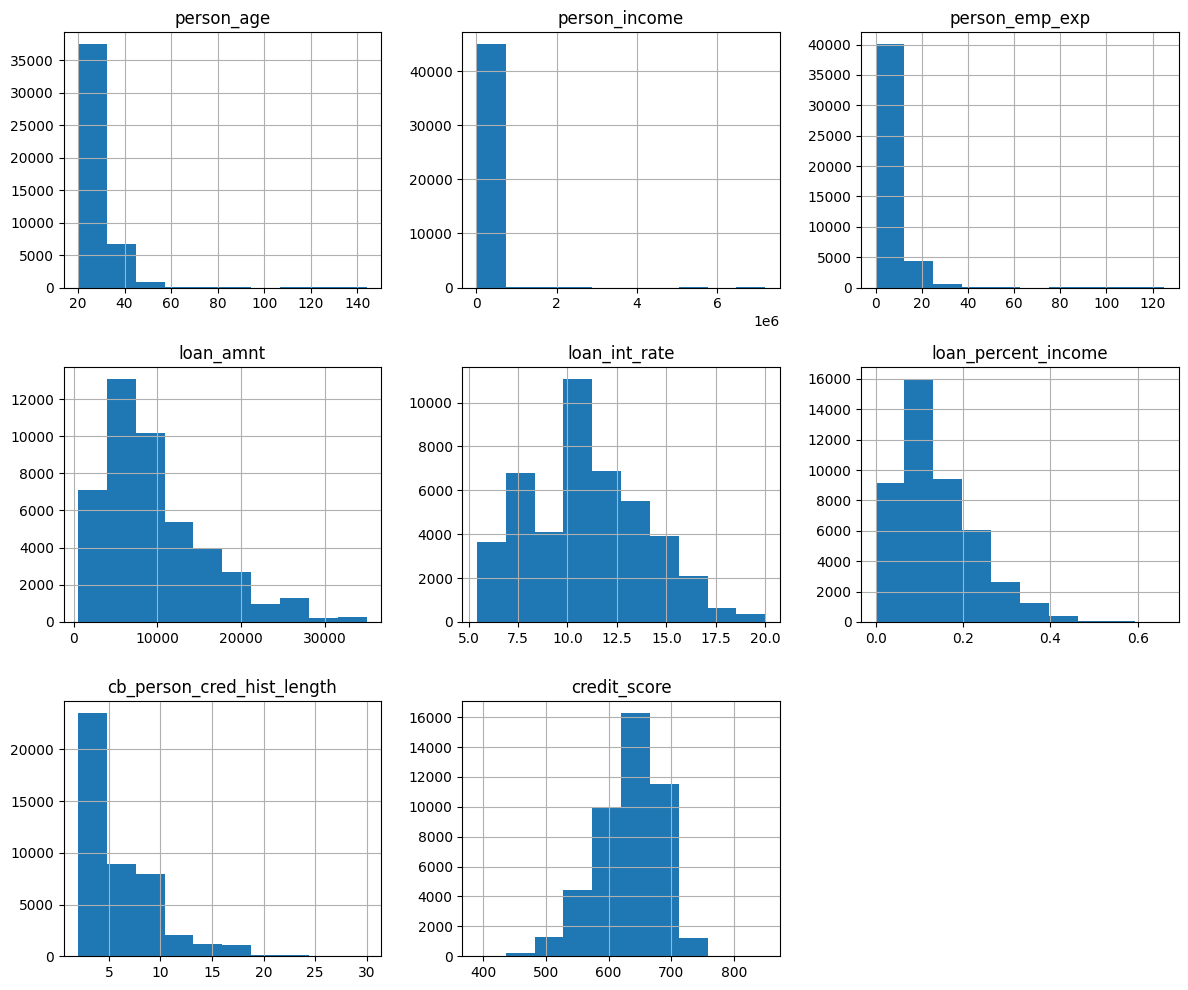

In [3]:
# histograms for each numeric column in one figure
number_variables = df.select_dtypes(include=[np.number])
number_variables.drop(columns=['loan_status'], inplace=True, errors='ignore')
number_variables.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Correlation Matrix')

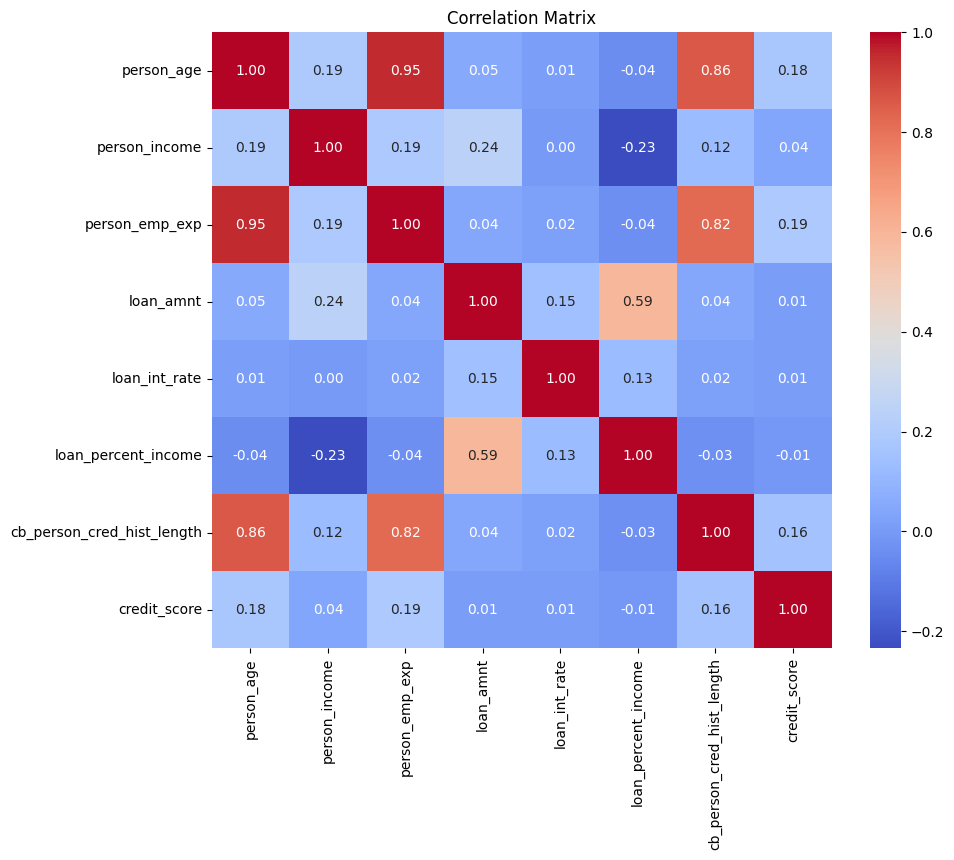

In [4]:
# correlation matrix
import seaborn as sns
corr = number_variables.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')

1. Naive Bayes: Didelė koreliacija tarp cb_person_cred_hist_lenght (kiek metų žmogaus kredito istorijos yra) koreliuoja su žmogaus amžiumi. Reikia Bayesui naikinti vieną iš šių požymių. Taip pat person_emp_exp ir cb_person_cred_hist_length, žmogaus darbo patirtis ir kredito istorijos ilgis. Logiška, nes kuo ilgiau žmogus dirbo, tuo didesnę kredito istoriją turi. Irgi reikia naikinti vieną iš jų. Tas pats su cb_person_cred_hist_lenght ir person_age.

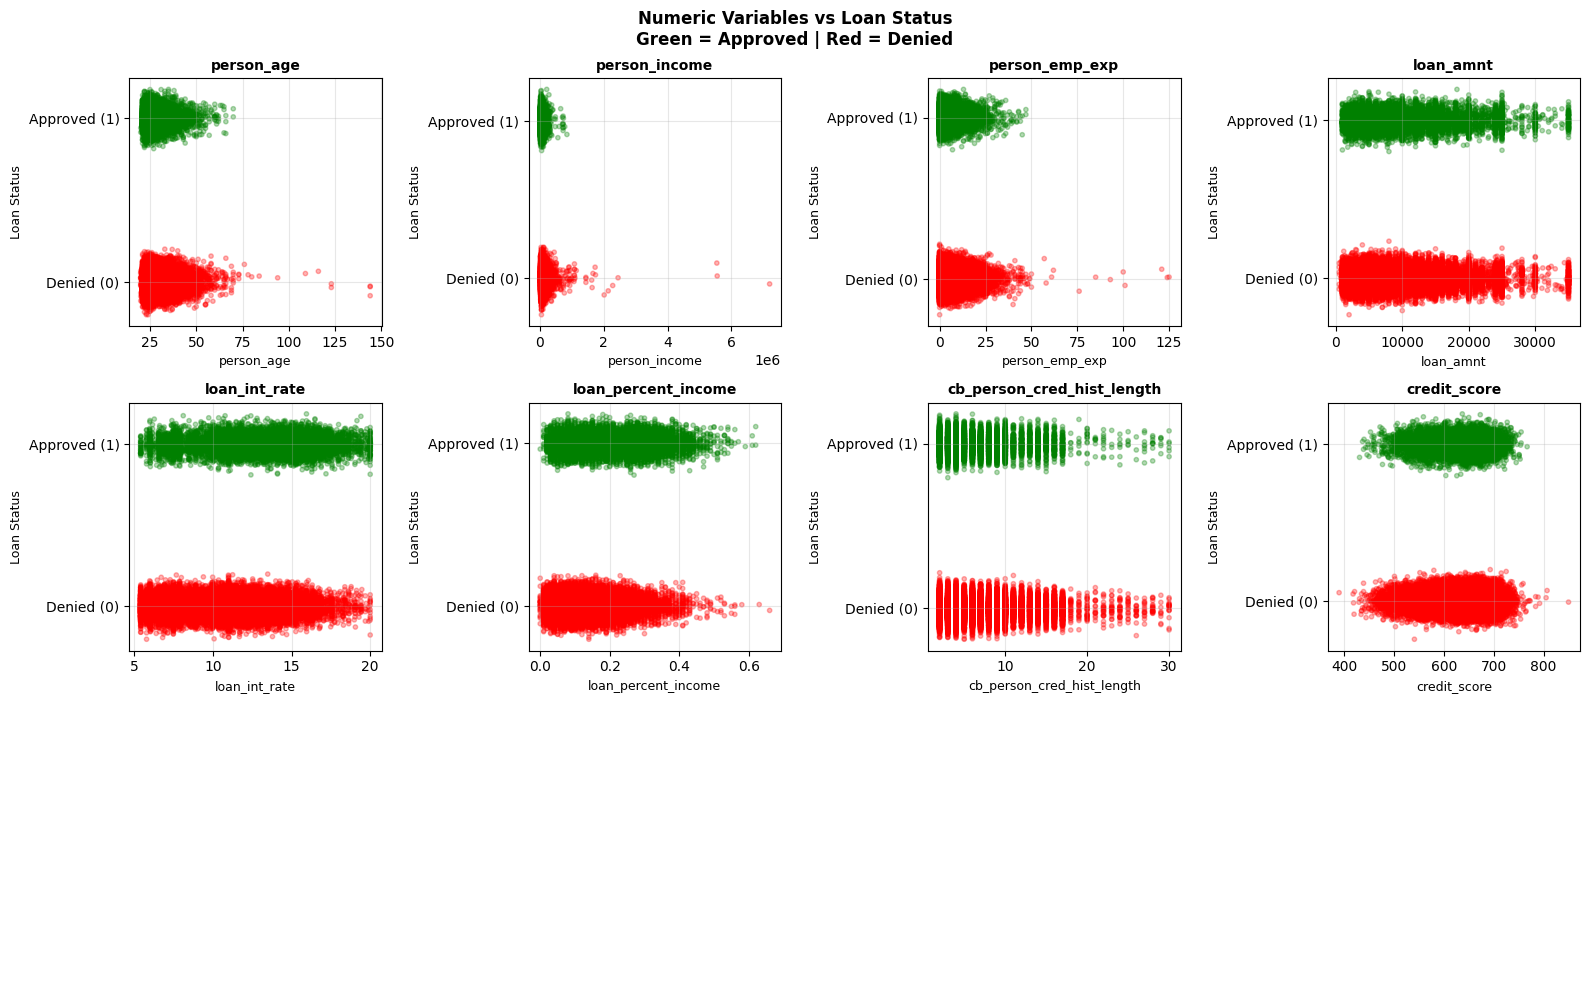

In [5]:
# scatter plots for numeric variables vs loan_status
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.ravel()

for idx, column in enumerate(number_variables.columns):
    # Add jitter to y-axis for better visualization (since loan_status is binary)
    jitter = np.random.normal(0, 0.05, size=len(df))
    colors = df['loan_status'].map({0: 'red', 1: 'green'})
    
    axes[idx].scatter(df[column], df['loan_status'] + jitter, 
                      c=colors, alpha=0.3, s=10)
    axes[idx].set_xlabel(column, fontsize=9)
    axes[idx].set_ylabel('Loan Status', fontsize=9)
    axes[idx].set_title(column, fontsize=10, fontweight='bold')
    axes[idx].set_yticks([0, 1])
    axes[idx].set_yticklabels(['Denied (0)', 'Approved (1)'])
    axes[idx].grid(True, alpha=0.3)

# Hide any unused subplots
for idx in range(len(number_variables.columns), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Numeric Variables vs Loan Status\nGreen = Approved | Red = Denied', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Matoma, kad didžioji dalis skaitinių kintamųjų nėra itin svarbūs, jų pasiskirstymas stipriai nesiskiria tarp klasių. Matomi tam tikri šablonai tik ties amžiumi, paskolos palūkanų norma, žmogaus pajamomis.

In [6]:
categorical_variables = df.select_dtypes(include=['object'])
categorical_variables.nunique()

person_gender                     2
person_education                  5
person_home_ownership             4
loan_intent                       6
previous_loan_defaults_on_file    2
dtype: int64

Random Forest: Kategorijas reiks hot-encode, tai jei bus labai daug stulpelių, per daug gilūs RF medžiai.
Galima naudoti SMOTE Random Forest, kuris atbalansuos dataseto klases.
XGBoost naudoti sample_pos_weight,
Random Forest: class_weight='balanced'.
Naive Bayes priors modifikuoti, kad klasės turėtų tokius pat svorius.

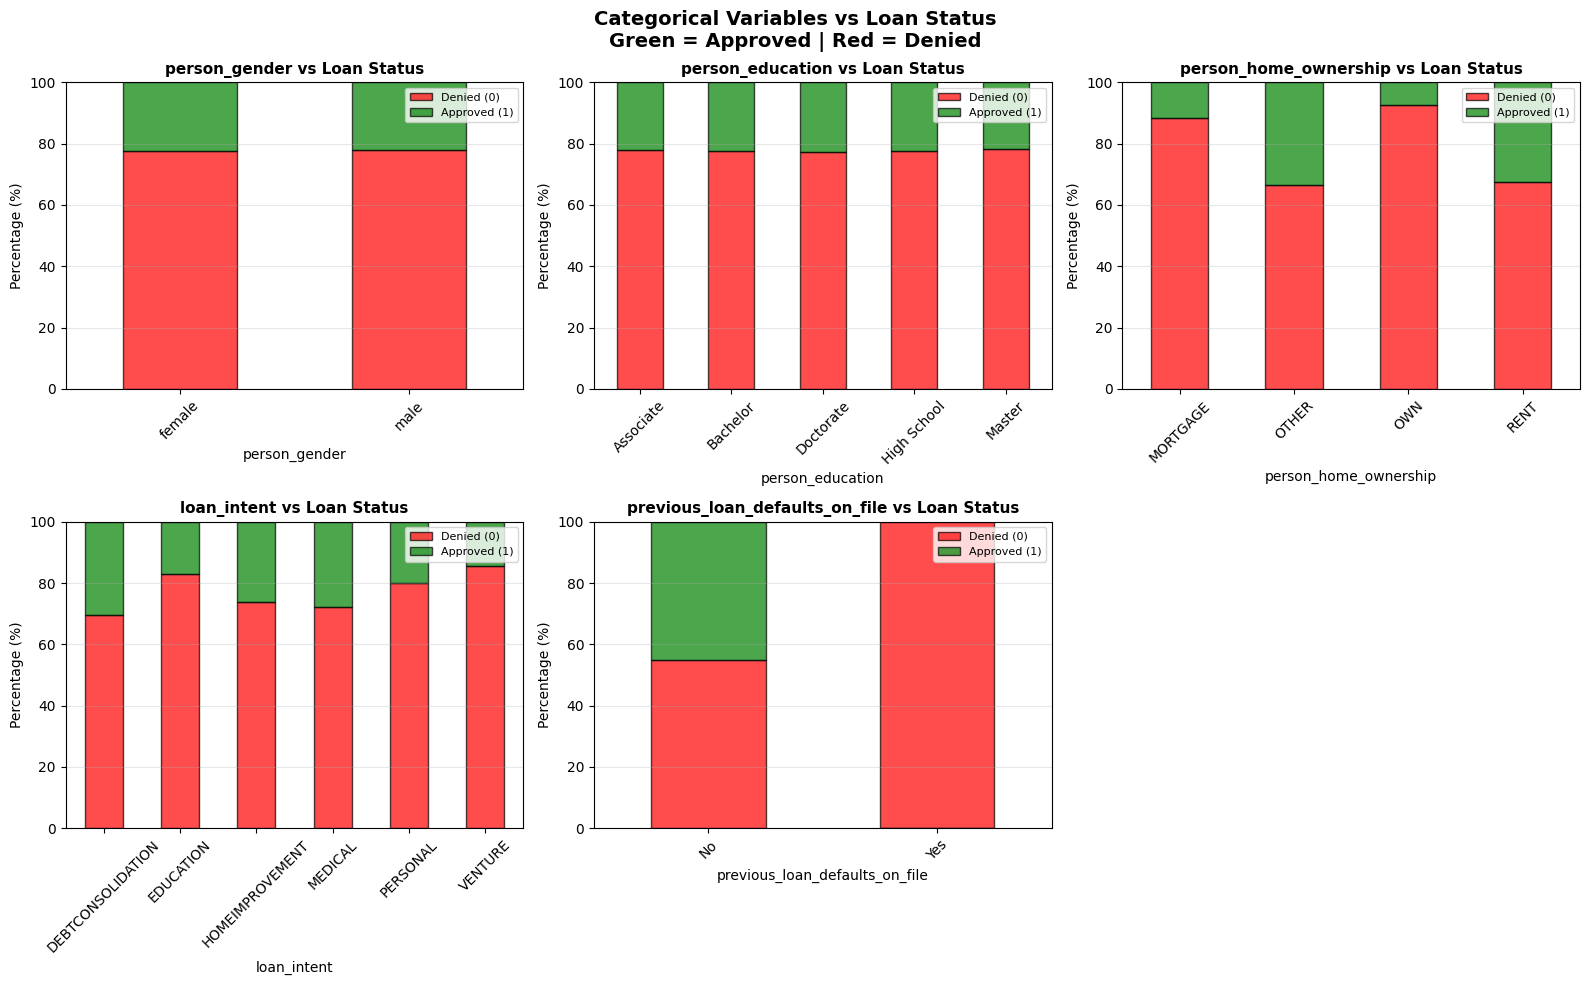

In [7]:
# categories VS loan_status
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, column in enumerate(categorical_variables.columns):
    # Create a crosstab to show proportions
    ct = pd.crosstab(df[column], df['loan_status'], normalize='index') * 100
    
    # Plot stacked bar chart
    ct.plot(kind='bar', stacked=True, ax=axes[idx], 
            color=['red', 'green'], alpha=0.7, edgecolor='black')
    
    axes[idx].set_xlabel(column, fontsize=10)
    axes[idx].set_ylabel('Percentage (%)', fontsize=10)
    axes[idx].set_title(f'{column} vs Loan Status', fontsize=11, fontweight='bold')
    axes[idx].legend(['Denied (0)', 'Approved (1)'], loc='upper right', fontsize=8)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_ylim(0, 100)
    axes[idx].grid(True, alpha=0.3, axis='y')

# Hide any unused subplots
for idx in range(len(categorical_variables.columns), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Categorical Variables vs Loan Status\nGreen = Approved | Red = Denied', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Matoma, kad svarbiausios kategorijos: paskolos paskirtis, praeitų paskolų negrąžinimas ir NT turėjimas. Šios kategorijos gali stipriai paveikti modelius, ypač tokius, kurie kategorijas gali skaityti tiesiogiai, kaip CatBoost

In [8]:
from scipy.stats import chi2_contingency

def run_chi_square(df, col_name):
    # Create a cross-tabulation (Count matrix)
    crosstab = pd.crosstab(df[col_name], df['loan_status'])
    
    # Run the test
    stat, p, dof, expected = chi2_contingency(crosstab)
    
    print(f"--- Analysis for {col_name} ---")
    print(f"P-value: {p:.5f}")
    if p < 0.05:
        print("RESULT: Significant!\n")
    else:
        print("RESULT: Not Significant.\n")

for col in categorical_variables:
    run_chi_square(df, col)

--- Analysis for person_gender ---
P-value: 0.91425
RESULT: Not Significant.

--- Analysis for person_education ---
P-value: 0.73283
RESULT: Not Significant.

--- Analysis for person_home_ownership ---
P-value: 0.00000
RESULT: Significant!

--- Analysis for loan_intent ---
P-value: 0.00000
RESULT: Significant!

--- Analysis for previous_loan_defaults_on_file ---
P-value: 0.00000
RESULT: Significant!



Chi kvadrato testas patvirtino hipotezę: Kategoriniai kintamieji, kurie yra reikšmingi modeliui yra NT būsena, paskolos paskirtis ir praeities paskolų negrąžinimas.

## Random Forest modelio kūrimas, atsakymas į klausimą:
Which feature affects the denial of a loan the most?

Training Random Forest...
Predicting...
Predicting...

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      7000
           1       0.78      0.88      0.83      2000

    accuracy                           0.92      9000
   macro avg       0.87      0.90      0.89      9000
weighted avg       0.92      0.92      0.92      9000


--- Confusion Matrix ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      7000
           1       0.78      0.88      0.83      2000

    accuracy                           0.92      9000
   macro avg       0.87      0.90      0.89      9000
weighted avg       0.92      0.92      0.92      9000


--- Confusion Matrix ---


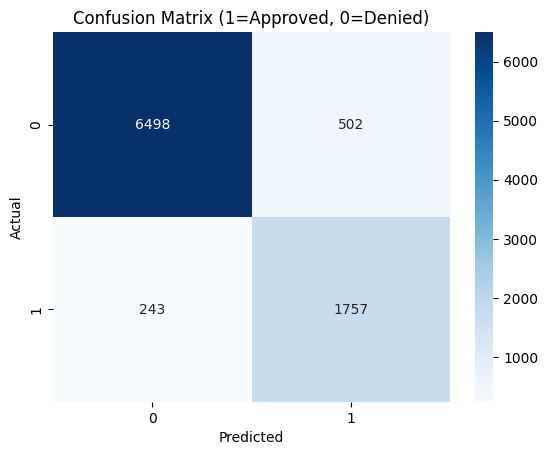

C:\Users\Klaudija\AppData\Local\Temp\ipykernel_16864\174810612.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')


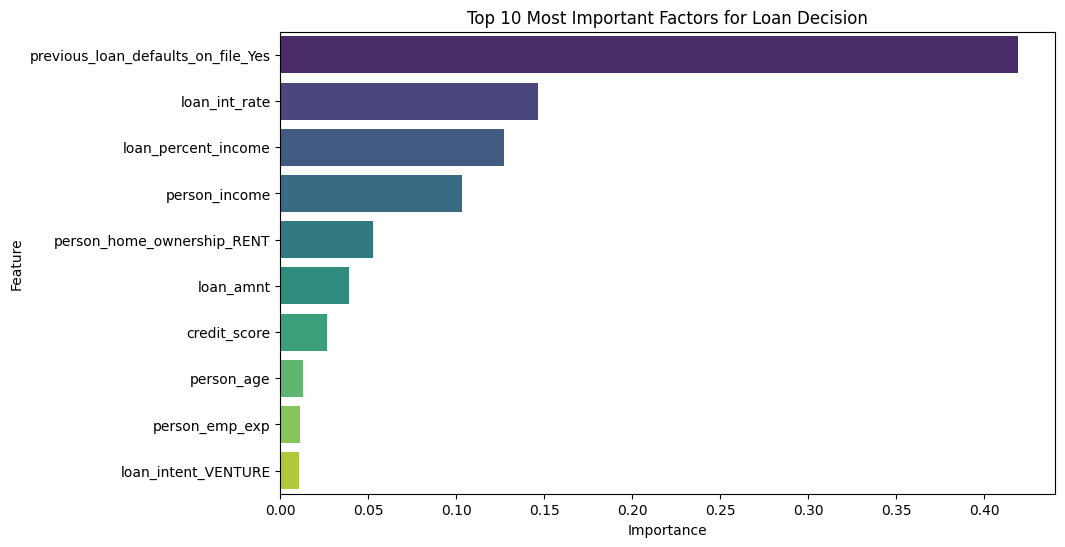

In [9]:
categorical_names =categorical_variables.columns
number_names = number_variables.columns
target = 'loan_status'

X = df.drop(target, axis=1)
y = df[target]

# Split Data (Stratify ensures we keep the same ratio of defaults in train and test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, categorical_names)
    ],
    remainder='passthrough'  # This passes through numeric columns unchanged
)

rf_model = RandomForestClassifier(
    n_estimators=400,           # Number of trees
    max_depth=30,               # Prevents the tree from getting too complex (overfitting)
    min_samples_leaf=7,         # Requires at least 7 people in a leaf to make a decision
    class_weight='balanced',    # CRITICAL: Fixes the imbalance (Approved vs Denied)
    random_state=42,
    n_jobs=-1                   # Uses all computer cores to speed up training
)

# E. Stick it all together
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

print("Training Random Forest...")
clf.fit(X_train, y_train)

print("Predicting...")
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test) # Probability of Default

# ---------------------------------------------------------
# 4. EVALUATE PERFORMANCE
# ---------------------------------------------------------
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (1=Approved, 0=Denied)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Get categorical feature names after encoding
categorical_feature_names = list(clf.named_steps['preprocessor']
                                   .named_transformers_['cat']
                                   .named_steps['encoder']
                                   .get_feature_names_out(categorical_names))
# Combine: categorical features first (from transformers), then numeric (from remainder='passthrough')
feature_names = categorical_feature_names + number_names.tolist()
# Get importance values from the model
importances = clf.named_steps['classifier'].feature_importances_

# Create a DataFrame to plot
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title('Top 10 Most Important Factors for Loan Decision')
plt.show()

c:\Users\Klaudija\anaconda3\envs\hyarchis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


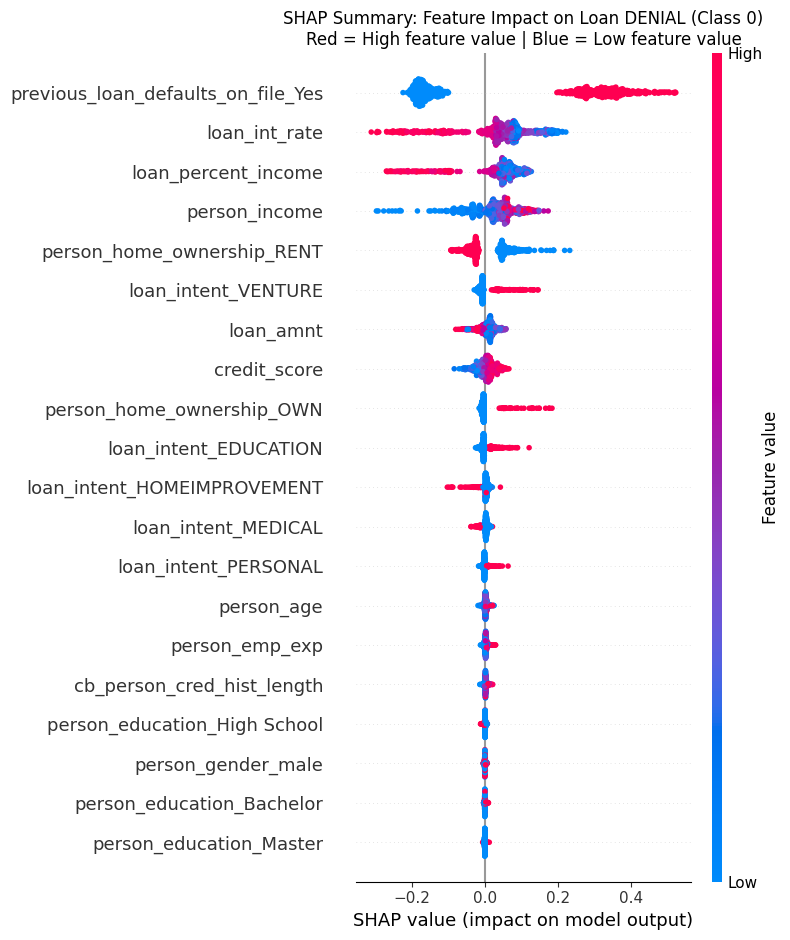

In [10]:
import shap

# Transform the test data using the preprocessor
X_test_transformed = clf.named_steps['preprocessor'].transform(X_test)

# Create SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(clf.named_steps['classifier'])

# Calculate SHAP values (use a sample for faster computation)
sample_size = min(700, X_test_transformed.shape[0])
X_sample = X_test_transformed[:sample_size]
shap_values = explainer.shap_values(X_sample)

# Handle different SHAP output formats - for class 0 (Denied)
if isinstance(shap_values, list):
    shap_values_class0 = shap_values[0]  # Class 0 = Denied
elif len(shap_values.shape) == 3:
    shap_values_class0 = shap_values[:, :, 0]
else:
    shap_values_class0 = shap_values

# --- SHAP Summary Plot (Beeswarm) - Shows direction AND magnitude ---
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_class0, X_sample, feature_names=feature_names, show=False, max_display=20)
plt.title('SHAP Summary: Feature Impact on Loan DENIAL (Class 0)\nRed = High feature value | Blue = Low feature value', fontsize=12)
plt.tight_layout()
plt.show()

Išvada:
1. Modelio tikslumas gana didelis, tačiau recall paskolos patvirtinimo klasei yra mažesnis, tai galėtų būti problema, nes bankui geriau apsidrausti ir spėti, kad paskolos yra geriau neduoti, nei išduoti rizikingai. 
2. Svarbiausi požymiai yra praeities paskolos negrąžinimas ir paskolos palūkanų norma. Iš SHAP analizės matoma, kad kategorinis kintamasis previous_loan_defaults_on_file_YES, turėdamas reikšmę 1, labai stipriai stumia modelį, kad atmesti paskolos prašymą. Tai reiškia, kad modelis daugiausiai dėmesio suteikia, ar žmogus yra negrąžinęs paskolos praeityje. Kai reikšmė 0, modelis žmogų vertina teigiamai, t.y. stumia rezultatą į teigiamą paskolos išdavimo pusę.
3. loan_int_rate yra antras svarbiausias požymis modeliui. Aukšta palūkanų norma stumia modelį į paskolos patvirtinimo pusę, tuo metu maža palūkanų norma mažina tikimybę gauti paskolą. Tai taip pat yra logiška, bankui labiau apsimoka patvirtinti tokią paskolą, todėl tai yra skatinamasis požymis, kai jo reikšmė didėja.

## XGBOOST model
Kaip modeliai klasifikuoja nelogiškus variantus "rich fails", kurie turi dideles pajamas, tačiau yra neatidavę paskolos praeityje?


Scale pos weight: 3.50

--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      7000
           1       0.77      0.91      0.83      2000

    accuracy                           0.92      9000
   macro avg       0.87      0.91      0.89      9000
weighted avg       0.93      0.92      0.92      9000


--- XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      7000
           1       0.77      0.91      0.83      2000

    accuracy                           0.92      9000
   macro avg       0.87      0.91      0.89      9000
weighted avg       0.93      0.92      0.92      9000



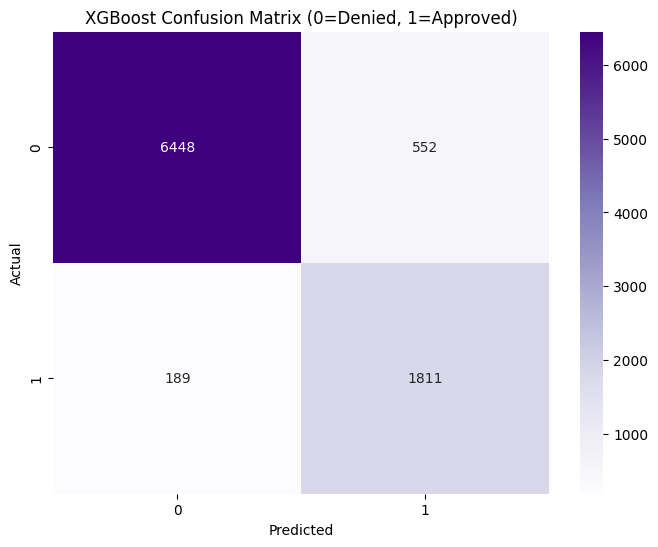


ROC AUC Score: 0.9795


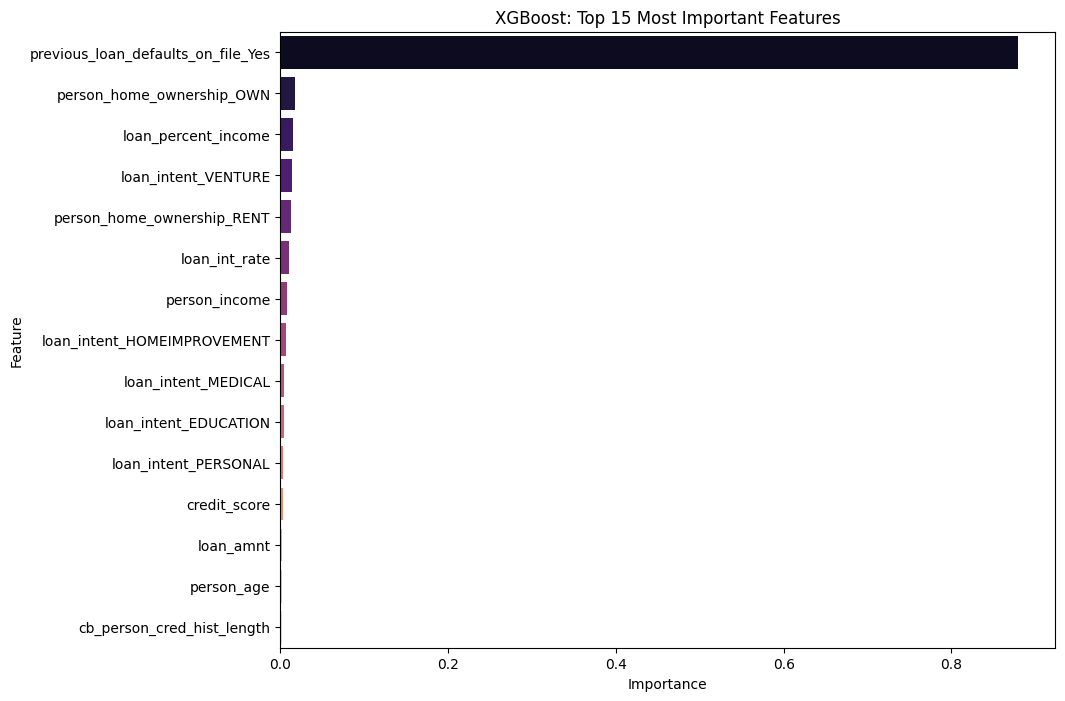


ANALYSIS: How does XGBoost classify 'RICH FAILS'?
(High income + Previous loan defaults)

High income threshold (75th percentile): $95,789

Found 1288 'rich fails' in test set

Model's Decision for 'Rich Fails':
  - APPROVED: 185 (14.4%)
  - DENIED:   1103 (85.6%)

Actual outcomes in test set:
  - Actually got loan: 0
  - Actually denied:   1288


In [ ]:
import xgboost as xgb 

# Paruošti duomenis su One-Hot kodavimu XGBoost modeliui
# One-hot encoding paverčia kategorijas į 0 ir 1, o drop_first=True išmeta pirmą kategoriją iš kiekvieno kintamojo, kad išvengtume multikolinearumo
X_train_xgb = pd.get_dummies(X_train, columns=categorical_names, drop_first=True)
X_test_xgb = pd.get_dummies(X_test, columns=categorical_names, drop_first=True)

# Užtikrinti, kad treniravimo ir testo duomenys turėtų tuos pačius stulpelius po one-hot encoding
X_test_xgb = X_test_xgb.reindex(columns=X_train_xgb.columns, fill_value=0)

# Apskaičiuoti scale_pos_weight klasių disbalansui kompensuoti
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Inicializuoti XGBoost modelį
xgb_model = xgb.XGBClassifier(
    n_estimators=300,        # Medžių skaičius 
    max_depth=6,             # Maksimalus medžio gylis
    learning_rate=0.1,       # Mokymosi greitis
    scale_pos_weight=scale_pos_weight,  # Teigiamų atvejų svoris disbalansui kompensuoti
    random_state=42,         # Rezultatų atkuriamumas
    eval_metric='logloss'    # Logistinio nuostolio metrika
)

# Treniruoti modelį
xgb_model.fit(X_train_xgb, y_train)

# Prognozės
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_probs_xgb = xgb_model.predict_proba(X_test_xgb)

# Klasifikacijos ataskaita
print("\n--- XGBoost Classification Report ---")
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples')
plt.title('XGBoost Confusion Matrix (0=Denied, 1=Approved)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC AUC rezultatas
roc_auc_xgb = roc_auc_score(y_test, y_probs_xgb[:, 1])
print(f"\nROC AUC Score: {roc_auc_xgb:.4f}")

# Požymių svarba
feature_importance_xgb = pd.DataFrame({
    'Feature': X_train_xgb.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_xgb, hue='Feature', palette='magma', legend=False)
plt.title('XGBoost: Top 15 Most Important Features')
plt.show()

# ==========================================
# ATSAKYMAS Į KLAUSIMĄ: "Rich Fails" analizė
# ==========================================
print("\n" + "="*70)
print("ANALIZĖ: Kaip XGBoost klasifikuoja 'RICH FAILS'?")
print("(Didelės pajamos + Ankstesnis paskolų negrąžinimas)")
print("="*70)

# Apibrėžti "rich fails" - didelės pajamos, bet turėjo ankstesnių nemokumų
high_income_threshold = df['person_income'].quantile(0.75)  # Viršutinis 25% pajamų
print(f"\nAukštų pajamų riba (75-asis percentilis): ${high_income_threshold:,.0f}")

# Rasti "rich fails" testo rinkinyje
test_indices = X_test.index
rich_fails_mask = (
    (df.loc[test_indices, 'person_income'] >= high_income_threshold) & 
    (df.loc[test_indices, 'loan_percent_income'] < 0.3) &  # Kad paskola nebūtų per didelė
    (df.loc[test_indices, 'previous_loan_defaults_on_file'] == 'Yes')
)

rich_fails = X_test[rich_fails_mask]
rich_fails_actual = y_test[rich_fails_mask]

if len(rich_fails) > 0:
    # Gauti prognozes "rich fails" grupei
    rich_fails_encoded = pd.get_dummies(rich_fails, columns=categorical_names, drop_first=True)
    rich_fails_encoded = rich_fails_encoded.reindex(columns=X_train_xgb.columns, fill_value=0)
    
    rich_fails_pred = xgb_model.predict(rich_fails_encoded)
    rich_fails_proba = xgb_model.predict_proba(rich_fails_encoded)
    
    # Statistika
    approval_rate = (rich_fails_pred == 1).sum() / len(rich_fails_pred) * 100
    denial_rate = (rich_fails_pred == 0).sum() / len(rich_fails_pred) * 100
    
    print(f"\nRasta {len(rich_fails)} 'rich fails' atvejų testo rinkinyje")
    print(f"\nModelio sprendimas 'Rich Fails' grupei:")
    print(f"  - PATVIRTINTA: {(rich_fails_pred == 1).sum()} ({approval_rate:.1f}%)")
    print(f"  - ATMESTA:     {(rich_fails_pred == 0).sum()} ({denial_rate:.1f}%)")
    
    print(f"\nTikri rezultatai testo rinkinyje:")
    print(f"  - Iš tikrųjų gavo paskolą: {(rich_fails_actual == 1).sum()}")
    print(f"  - Iš tikrųjų negavo:       {(rich_fails_actual == 0).sum()}")
    


XGBoost modelis, pritaikytas paskolų patvirtinimo prognozavimui, pasiekė aukštą bendrą tikslumą – 92 %, kartu išlaikydamas gerą balansą tarp abiejų klasių. Modelis efektyviai identifikavo tiek paskolų negaunančius (0), tiek gavusius (1) asmenis, kas matyti iš santykinai aukšto f1 rodiklio abiem klasėms (0 klasė – 0.95, 1 klasė – 0.83). Svarbu tai, kad esant ryškiam klasių disbalansui (77 % negavo, 23 % gavo), modelis gebėjo išlaikyti gan aukštą recall gavusiųjų klasėje (91 %), o tai reiškia, kad jis beveik visada atpažįsta tuos, kuriems paskola turėtų būti suteikta. ROC AUC rezultatas taip pat patvirtina gerą atskyrimo gebėjimą tarp klasių. Kintamųjų svarbos analizė atskleidė, jog pats reikšmingiausias veiksnys yra ankstesnių paskolų įsipareigojimų nevykdymas, kuris ženkliai dominuoja prieš kitus požymius – tai rodo, kad XGBoost mokymosi metu stipriausiai remiasi kliento kredito istorija kaip pagrindiniu rizikos rodikliu. Apibendrinant, modelis prognozuoja stabiliai ir logiškai, išryškindamas svarbiausius finansinio patikimumo indikatorius.

Analizuojant atskirą klientų pogrupį – „rich fails“, t.y. dideles pajamas turinčius asmenis, kurie anksčiau yra neatidavę paskolų, paaiškėjo, kad XGBoost modelis yra itin konservatyvus. Nors šie klientai patenka į aukščiausias pajamas gaunančius (> 95 tūkst. USD), net 85.6 % iš jų modelis nusprendė nesuteikti paskolos, ir tik 14.4 % priskyrė prie galimai tinkamų finansavimui. Įdomu tai, kad realybėje visi 1288 šios grupės asmenys iš tiesų negavo paskolos.Tokia situacija leidžia daryti išvadą, kad aukštos pajamos modelio logikoje neatperka praeities finansinių pažeidimų: pagrindinis veiksnys yra kreditinė drausmė, o ne pajamų dydis. Modelis iš esmės atkartoja finansinių institucijų rizikos vertinimo principą – ankstesnis nemokumas yra pats stipriausias neigiamo sprendimo prediktorius, net ir „turtingiems“ klientams. 

## CatBoost Model
Answer to: how the non-financial features (human parameters, loan purpose) affect the loan receival?

Training CatBoost...
Predicting...

--- CatBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7000
           1       0.75      0.91      0.82      2000

    accuracy                           0.91      9000
   macro avg       0.86      0.91      0.88      9000
weighted avg       0.92      0.91      0.92      9000


--- Confusion Matrix ---
Predicting...

--- CatBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7000
           1       0.75      0.91      0.82      2000

    accuracy                           0.91      9000
   macro avg       0.86      0.91      0.88      9000
weighted avg       0.92      0.91      0.92      9000


--- Confusion Matrix ---


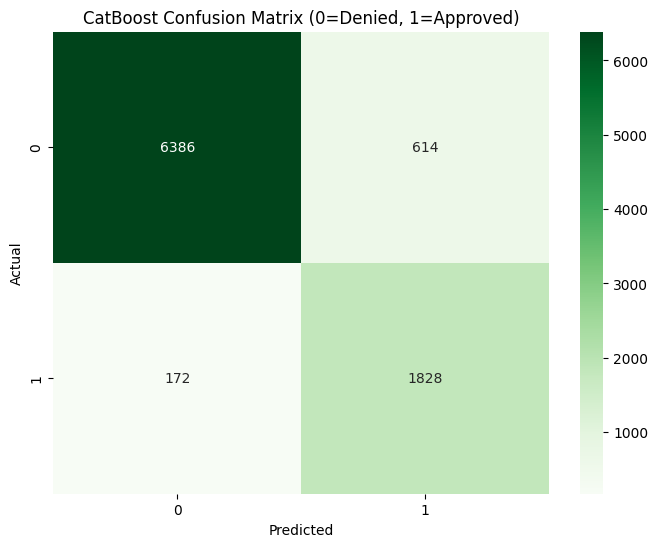


ROC AUC Score: 0.9789


C:\Users\Klaudija\AppData\Local\Temp\ipykernel_16864\2026097116.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_cat, palette='viridis')


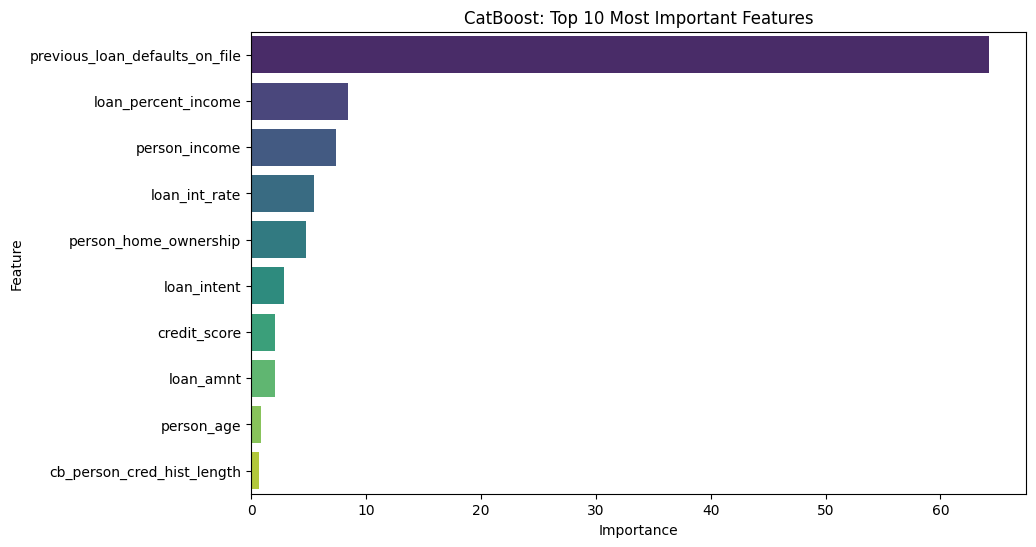

In [12]:
from catboost import CatBoostClassifier

categorical_variables = list(categorical_names)

# Initialize model (No pipeline needed for categories!)
model = CatBoostClassifier(
    cat_features=categorical_variables, 
    verbose=0,
    random_state=42,
    auto_class_weights='Balanced'  # Handle class imbalance
)

# Fit directly on raw dataframe
print("Training CatBoost...")
model.fit(X_train, y_train)

# Predict
print("Predicting...")
y_pred_cat = model.predict(X_test)
y_probs_cat = model.predict_proba(X_test)

# Classification Report
print("\n--- CatBoost Classification Report ---")
print(classification_report(y_test, y_pred_cat))

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm_cat = confusion_matrix(y_test, y_pred_cat)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cat, annot=True, fmt='d', cmap='Greens')
plt.title('CatBoost Confusion Matrix (0=Denied, 1=Approved)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC AUC Score
roc_auc_cat = roc_auc_score(y_test, y_probs_cat[:, 1])
print(f"\nROC AUC Score: {roc_auc_cat:.4f}")

# Feature Importance
feat_imp_cat = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_cat, palette='viridis')
plt.title('CatBoost: Top 10 Most Important Features')
plt.show()

### Gaussian Naive Bayes: Matematinis pagrindas

Gaussian Naive Bayes remiasi Bayeso teorema, kuri leidžia apskaičiuoti klasės tikimybę, turint tam tikrus požymius:

$$P(y|X) = \frac{P(X|y) \cdot P(y)}{P(X)}$$

kur $y$ – klasė (paskolos patvirtinimas/atmetimas), $X$ – požymių vektorius (pajamos, amžius, kredito istorija).

**Pagrindinė prielaida:** teigia, kad kiekvienas požymis prisideda prie klasifikacijos nepriklausomai nuo kitų požymių reikšmių, esant fiksuotai klasėje. Tai reiškia, kad žinojimas apie vieną požymį (pvz., amžių) nesuteikia jokios papildomos informacijos apie kitą požymį (pvz., pajamas). Matematiškai tai išreiškiama kaip sąlyginė nepriklausomybė: $P(x_i | x_j, y) = P(x_i | y)$.Ši prielaida leidžia išskaidyti bendrą tikimybę į atskirų tikimybių sandaugą:

$$P(X|y) = \prod_{i=1}^{n} P(x_i|y)$$

**Gaussian prielaida:** Kiekvienas skaitinis požymis $x_i$ klasėje $y$ pasiskirstęs pagal normalųjį (Gauso) pasiskirstymą su vidurkiu $\mu_{iy}$ ir dispersija $\sigma_{iy}^2$:

$$P(x_i|y) = \frac{1}{\sqrt{2\pi\sigma_{iy}^2}} \exp\left(-\frac{(x_i - \mu_{iy})^2}{2\sigma_{iy}^2}\right)$$

Mokymo metu modelis įvertina vidurkius ir dispersijas kiekvienam požymiui kiekvienoje klasėje iš treniravimo duomenų. Prognozuojant naują objektą, jis apskaičiuoja tikimybes abiem klasėms ir pasirenka didesnę. Dėl to Naive Bayes yra greitai treniruojamas ir efektyvus net su dideliais duomenų kiekiais, tačiau jautrus multikolinearumui ir nenormaliajam duomenų pasiskirstymui (todėl šiame darbe naudojome PowerTransformer ir pašalinome koreliuotus požymius).

## Naive Bayes
Kaip loan_intent and person_home_ownership kombinacijos paveikia paskolos gavimo tikimybę?

Removing highly correlated features for Naive Bayes:
  - Dropping: ['person_emp_exp', 'cb_person_cred_hist_length']
  - Reason: High correlation with person_age (0.95 and 0.86)

Using balanced priors: [0.5, 0.5]

--- Naive Bayes Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.68      0.81      7000
           1       0.47      0.98      0.64      2000

    accuracy                           0.75      9000
   macro avg       0.73      0.83      0.72      9000
weighted avg       0.88      0.75      0.77      9000


--- Naive Bayes Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.68      0.81      7000
           1       0.47      0.98      0.64      2000

    accuracy                           0.75      9000
   macro avg       0.73      0.83      0.72      9000
weighted avg       0.88      0.75      0.77      9000



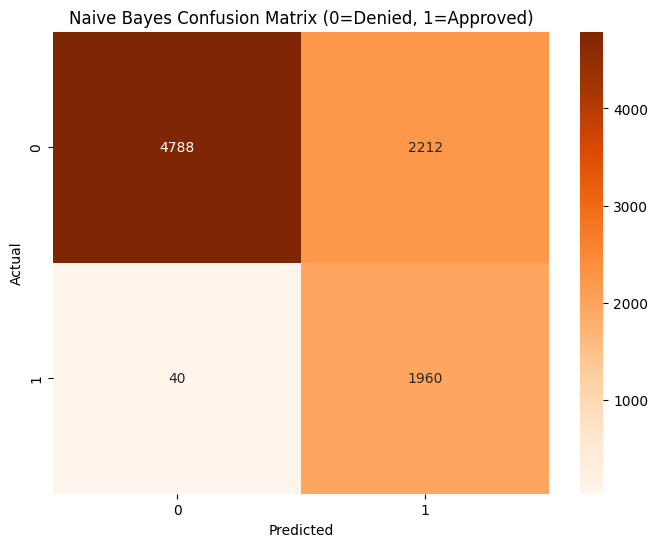


ROC AUC Score: 0.9424


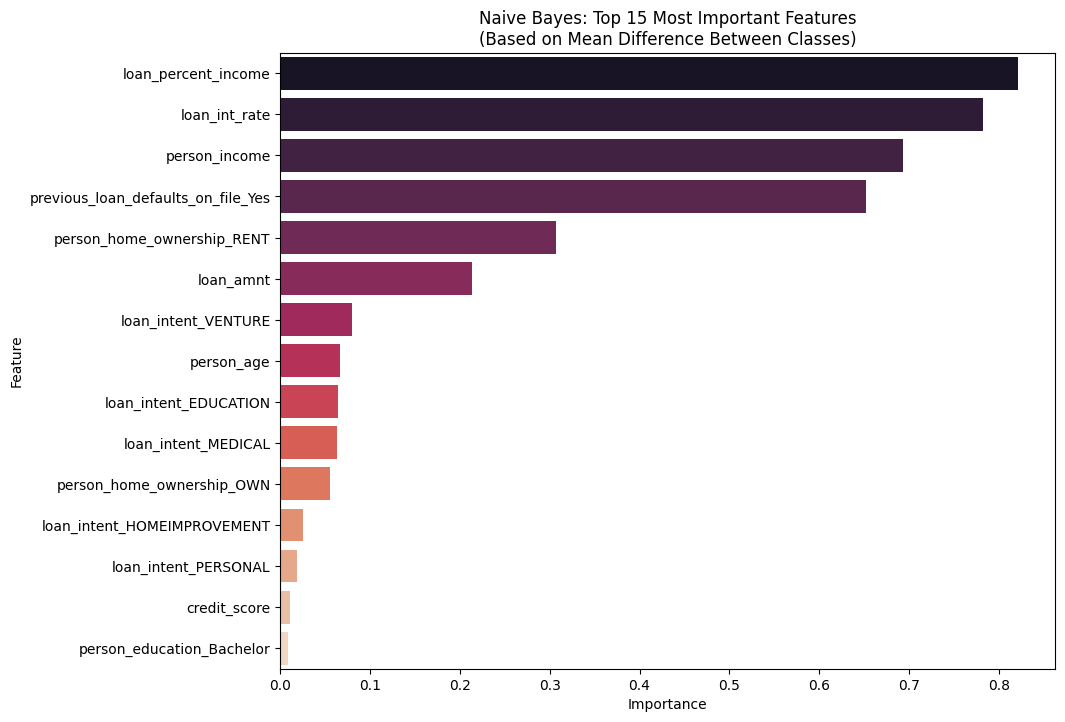

NAIVE BAYES ANALYSIS: Loan Intent & Home Ownership Impact
Question: Which combinations have highest approval rates?

--- ACTUAL DATA: Approval Rates by Category Combination ---

      Loan Intent Home Ownership  Count  Actual Approval %  Model Approval %
        EDUCATION          OTHER      4          75.000000        100.000000
          MEDICAL          OTHER      2          50.000000         50.000000
DEBTCONSOLIDATION          OTHER      6          50.000000         83.333333
  HOMEIMPROVEMENT           RENT    426          43.427230         63.145540
DEBTCONSOLIDATION           RENT    791          38.938053         57.395702
          MEDICAL           RENT    991          33.198789         57.013118
         PERSONAL           RENT    795          30.314465         55.849057
          VENTURE           RENT    738          27.642276         50.813008
        EDUCATION           RENT    972          26.440329         52.469136
          MEDICAL       MORTGAGE    558          19.

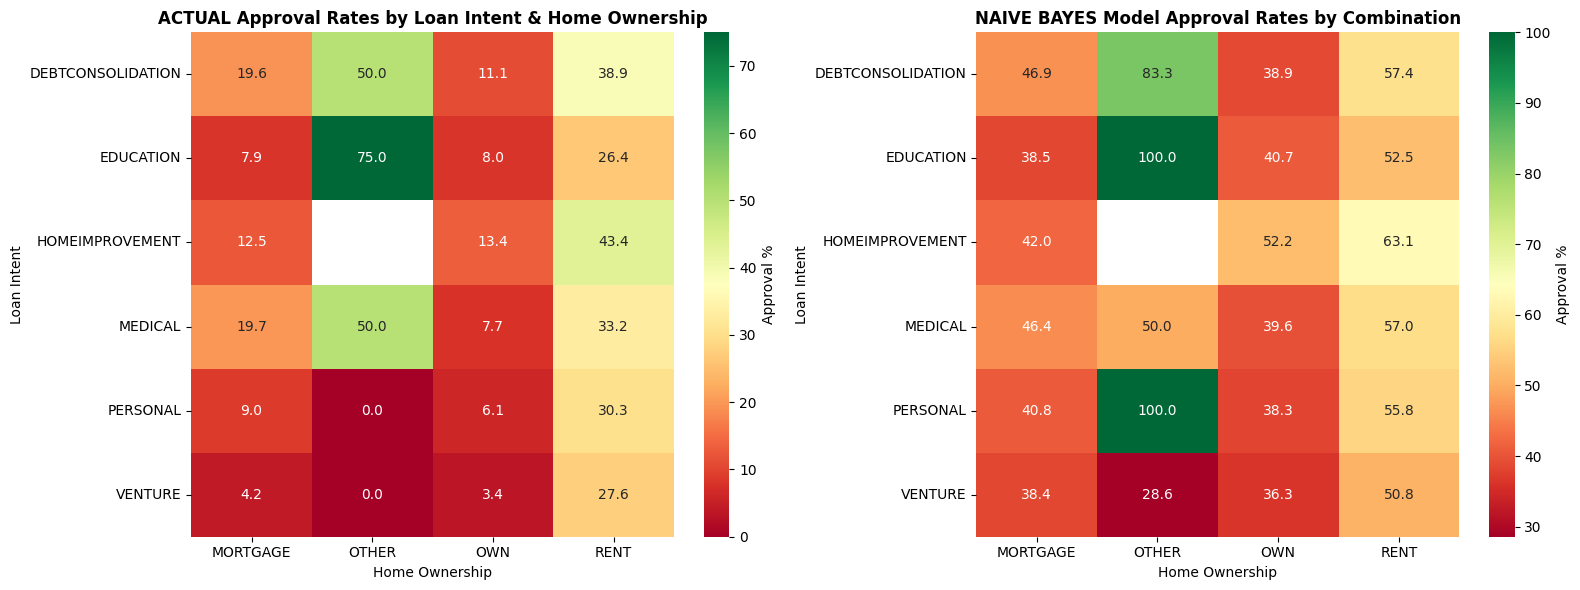

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer

# Naudoti jau užkoduotus duomenis iš XGBoost (X_train_xgb, X_test_xgb)
# Jie jau turi one-hot užkoduotas kategorines reikšmes

# Pašalinti stipriai koreliuotus požymius Naive Bayes modeliui
# Iš koreliacijos matricos: person_age & person_emp_exp (0.95), person_age & cb_person_cred_hist_length (0.86)
# Palikti tik: person_age (pašalinti person_emp_exp ir cb_person_cred_hist_length)
features_to_drop = ['person_emp_exp', 'cb_person_cred_hist_length']

print("Removing highly correlated features for Naive Bayes:")
print(f"  - Dropping: {features_to_drop}")
print(f"  - Reason: High correlation with person_age (0.95 and 0.86)")

X_train_nb = X_train_xgb.drop(columns=features_to_drop, errors='ignore')
X_test_nb = X_test_xgb.drop(columns=features_to_drop, errors='ignore')

# Pritaikyti transformacijas, kad skaitiniai požymiai būtų artimesni normaliam pasiskirstymui
# Iš histogramų: person_age, person_income, loan_amnt, loan_percent_income yra asimetriški
numeric_cols = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 
                'loan_percent_income', 'credit_score']

numeric_cols_to_transform = [col for col in numeric_cols if col in X_train_nb.columns]

if numeric_cols_to_transform:
    # PowerTransformer (Yeo-Johnson): Geresnis už log transformaciją, nes veikia ir su nulinėmis/neigiamomis reikšmėmis
    # Automatiškai parenka geriausią lambda parametrą kiekvienam požymiui
    # standardize=True - dar ir standartizuoja (mean=0, std=1)
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    
    # Išmokti transformaciją iš treniravimo duomenų ir pritaikyti abiem rinkiniams
    X_train_nb[numeric_cols_to_transform] = pt.fit_transform(X_train_nb[numeric_cols_to_transform]) # Išmoksta transformaciją iš treniravimo duomenų
    # Taiko tą pačią transformaciją test duomenims
    X_test_nb[numeric_cols_to_transform] = pt.transform(X_test_nb[numeric_cols_to_transform])

# Subalansuoti priors - suteikti vienodą svorį abiem klasėms
# Modelis privalo sprendimą priimti remdamasis požymiais
# (pajamomis, kredito istorija ir t.t.), o ne tiesiog sekdamas dažniausią klasę
balanced_priors = [0.5, 0.5]
print(f"\nUsing balanced priors: {balanced_priors}")

# Inicializuoti Naive Bayes su subalansuotais priors
nb_model = GaussianNB(priors=balanced_priors)

# Treniruoti modelį
nb_model.fit(X_train_nb, y_train)

# Prognozės
y_pred_nb = nb_model.predict(X_test_nb)
y_probs_nb = nb_model.predict_proba(X_test_nb)

# Klasifikacijos ataskaita
print("\n--- Naive Bayes Classification Report ---")
print(classification_report(y_test, y_pred_nb))

# Painiavos matrica
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Oranges')
plt.title('Naive Bayes Confusion Matrix (0=Denied, 1=Approved)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC AUC rezultatas
roc_auc_nb = roc_auc_score(y_test, y_probs_nb[:, 1])
print(f"\nROC AUC Score: {roc_auc_nb:.4f}")

# Požymių svarba Naive Bayes modelyje
# Gaussian NB atveju galime žiūrėti į vidurkį ir dispersiją kiekvienoje klasėje
# Požymiai su didesniu vidurkių skirtumu tarp klasių yra svarbesni

feature_importance_nb = []
for i, feature in enumerate(X_train_nb.columns):
    # Apskaičiuoti vidurkių skirtumą tarp klasių
    mean_class_0 = nb_model.theta_[0, i]  # Vidurkis klasei 0
    mean_class_1 = nb_model.theta_[1, i]  # Vidurkis klasei 1
    importance = abs(mean_class_1 - mean_class_0)
    feature_importance_nb.append({'Feature': feature, 'Importance': importance})

feat_imp_nb = pd.DataFrame(feature_importance_nb).sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_nb, hue='Feature', palette='rocket', legend=False)
plt.title('Naive Bayes: Top 15 Most Important Features\n(Based on Mean Difference Between Classes)')
plt.show()


print("NAIVE BAYES ANALYSIS: Loan Intent & Home Ownership Impact")
print("Question: Which combinations have highest approval rates?")

# Gauti visas unikalias kombinacijas testo rinkinyje
test_indices = X_test.index # Gauti test rinkinio eilučių indeksus
combinations_analysis = []

# Apibrėžti kategorijas analizei
loan_intents = df['loan_intent'].unique()
home_ownerships = df['person_home_ownership'].unique()

print("\n--- ACTUAL DATA: Approval Rates by Category Combination ---\n")

for intent in loan_intents:
    for home in home_ownerships:
        # Paimti tik tas eilutes iš test rinkinio, kurios atitinka šiuos du kintamuosius
        mask = (
            (df.loc[test_indices, 'loan_intent'] == intent) & 
            (df.loc[test_indices, 'person_home_ownership'] == home)
        )
        
        if mask.sum() > 0:  
            subset_actual = y_test[mask] # Gauti tikrus rezultatus šioms eilutėms
            actual_approval_rate = (subset_actual == 1).sum() / len(subset_actual) * 100 # Kiek procentų iš tos kombinacijos gavo paskolą
            
            # Gauti modelio prognozes šiam pogrupiui
            subset_X = X_test[mask] # Gauti X duomenis tik šiai kombinacijai
            subset_encoded = pd.get_dummies(subset_X, columns=categorical_names, drop_first=True) # One-hot kodavimas
            subset_encoded = subset_encoded.reindex(columns=X_train_xgb.columns, fill_value=0) # Suderinti stulpelius
            subset_encoded_nb = subset_encoded.drop(columns=features_to_drop, errors='ignore') # Pašalinti koreliuotus požymius
            
            # Pritaikyti tą pačią transformaciją visiems skaitiniams stulpeliams
            cols_present = [col for col in numeric_cols_to_transform if col in subset_encoded_nb.columns]
            if cols_present:
                subset_encoded_nb[cols_present] = pt.transform(subset_encoded_nb[cols_present])
            
            subset_pred = nb_model.predict(subset_encoded_nb) # Klasifikacija (0 arba 1)
            
            model_approval_rate = (subset_pred == 1).sum() / len(subset_pred) * 100
            
            combinations_analysis.append({
                'Loan Intent': intent,
                'Home Ownership': home,
                'Count': mask.sum(),
                'Actual Approval %': actual_approval_rate,
                'Model Approval %': model_approval_rate
            })

# Sukurti DataFrame ir surūšiuoti pagal faktinį patvirtinimo procentą
combo_df = pd.DataFrame(combinations_analysis).sort_values('Actual Approval %', ascending=False)

# Atspausdinti rezultatus
print(combo_df.to_string(index=False))

# Vizualizuoti rezultatus
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grafikas 1: Tikrų patvirtinimo procentų šilumos žemėlapis
pivot_actual = combo_df.pivot(index='Loan Intent', columns='Home Ownership', values='Actual Approval %')
sns.heatmap(pivot_actual, annot=True, fmt='.1f', cmap='RdYlGn', ax=axes[0], cbar_kws={'label': 'Approval %'})
axes[0].set_title('ACTUAL Approval Rates by Loan Intent & Home Ownership', fontweight='bold')
axes[0].set_xlabel('Home Ownership')
axes[0].set_ylabel('Loan Intent')

# Grafikas 2: Modelio prognozuojamų patvirtinimo procentų šilumos žemėlapis
pivot_model = combo_df.pivot(index='Loan Intent', columns='Home Ownership', values='Model Approval %')
sns.heatmap(pivot_model, annot=True, fmt='.1f', cmap='RdYlGn', ax=axes[1], cbar_kws={'label': 'Approval %'})
axes[1].set_title('NAIVE BAYES Model Approval Rates by Combination', fontweight='bold')
axes[1].set_xlabel('Home Ownership')
axes[1].set_ylabel('Loan Intent')

plt.tight_layout()
plt.show()
 

Gaussian Naive Bayes modelis parodė gana stiprų klasifikacinį pajėgumą esant labai disbalansuotai duomenų klasei. Modelis ypač gerai identifikavo teigiamus atvejus („gavo paskolą“), išgaudamas net 98 % recall pozityviai klasei, t.y. beveik visus realiai patvirtintus paskolų atvejus pažymėjo teisingai. AUC rodiklis (0.94) taip pat rodo labai gerą modelio gebėjimą skirti klases pagal tikimybes. Vis dėlto, siekiant pasiekti tokį jautrumą 1 klasei, modelis paaukojo tikslumą 0 klasei — jis gana dažnai klaidingai priskyrė paskolą gavusiais tuos atvejus, kurie jos negavo, dėl to 0 klasės recall sumažėjo iki 68 %. Tokia elgsena yra tipiška Naive Bayes modeliui disbalansuotose finansinėse užduotyse: jis maksimalizuoja tiksliausią tikimybinį atskyrimą.

Analizuojant paskolų duomenis, aukščiausi patikimi patvirtinimo rodikliai fiksuojami tarp nuomininkų (RENT), ypač kai paskolos tikslas yra būsto gerinimas (HOMEIMPROVEMENT, 43,4%) arba skolų konsolidavimas (DEBTCONSOLIDATION, 38,9%). Nors kategorija OTHER formaliai rodo didžiausius procentus (pvz., EDUCATION + OTHER siekia 75%), itin mažas imties dydis (vos vienženkliai skaičiai) paverčia šiuos duomenis statistiniu triukšmu, o ne patikima tendencija. Pastebima, kad klientai, turintys būsto paskolą (MORTGAGE) arba nuosavą būstą (OWN), pasižymi gerokai žemesniais faktiniais patvirtinimo rodikliais (dauguma jų nesiekia 20%). Taip pat svarbu pabrėžti, kad Naive Bayes modelis sistemingai pervertina sėkmės tikimybę: modelio prognozuojami patvirtinimo procentai beveik visose kategorijose yra 15–30% didesni nei realūs duomenys.